<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F%20%D0%A2%D0%B5%D0%BA%D1%81%D1%82%D0%B0%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Создать сети для сегментациии договоров, оценить точность на проверочной выборке.

Взять лучшую архитектуру и провести несколько экспериментов, меняя гиперпараметры выбранной архитектуры



In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# устанавливаю лемматизатор (Лемматизация — процесс приведения словоформы к лемме — её нормальной (словарной) форме.)

In [12]:
!pip install -q pymorphy2             # лемматизатор pymorphy2

In [13]:
!pip install tensorflow==2.3 # устанавливаю версию tf 2.3 и делаю restart runtime

In [152]:
import numpy as np 
from tensorflow.keras.models import Model, load_model
import re                                                   # Имортируем чтобы работать с строками
from tensorflow.keras.preprocessing.text import Tokenizer   # Метод, который поволяет работать с текстами и конвертирует их в последовательности (индексов)
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D, LSTM, BatchNormalization, Dropout, Conv2DTranspose, Conv1DTranspose, Lambda
from tensorflow.keras import backend as K                   # Импортируем, чтобы высчитать dice_coef(ошибку)
from tensorflow.keras.optimizers import Adam, Adadelta 
from tensorflow.keras import utils                          # Импортируем для работы с категориальными данными
import tensorflow
from google.colab import files 
import matplotlib.pyplot as plt 
from gensim.models import word2vec                          # Импортируем gensim
import os 
import pandas as pd
import time 
import nltk                                                 # Natural language toolkit - Инструментарий естественного языка
from nltk.stem import WordNetLemmatizer                     # Импортируем для работы с леммами
import pymorphy2                                            # Импортируем для работы с леммами
from IPython.display import Image
from tensorflow.keras.utils import plot_model

nltk.download('wordnet')                                    # Скачиваем сетку слов для лемматизации

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

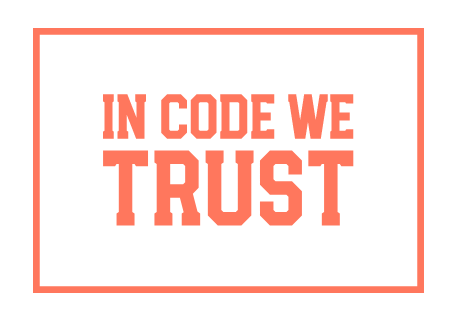

In [ ]:
Image("/content/drive/MyDrive/Logo/logo9.png", width=150, height=100)

In [ ]:
!unzip '//content/drive/MyDrive/Базы/Договора432-20210809T081459Z-001.zip' -d '//content/drive/MyDrive/Базы/Договоры 432/'

Archive:  //content/drive/MyDrive/Базы/Договора432-20210809T081459Z-001.zip
replace //content/drive/MyDrive/Базы/Договоры 432/Договора432/Трудовой контракт с руководителем предприятия о предпринимательской деятельности.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

##Создаю функции для работы с текстами:

In [ ]:
"""
<s1> - Условия
<s2> - Запреты
<s3> - Цена
<s4> - Условия (относительно дат)
<s5> - Штрафы
<s6> - Адреса и местоположения

Превращаю договоры в листы слов
"""

In [15]:
def readText(fileName):                     # Функция  удаляющая пунктуационные знаки препинания и дополнительные ненужные знаки

    f = open(fileName, 'r')                 # Открываю файл и считываю наши данные
    text = f.read()                         # Кладу текст в переменную
    
    delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";",'•','%'] # Какие знаки будут удалены

    for dS in delSymbols:                   
        text = text.replace(dS, " ")        # Удаляю знак, посредством замены этого знака на пробел
    # Выискиваю дополнительные знаки в текстах посредством паттернов и определяю на что их заменять
    text = re.sub("[.]", " ", text)
    text = re.sub(":", " ", text)
    text = re.sub("<", " <", text)
    text = re.sub(">", "> ", text)

    # split  метод разделит текст на последовательность слов при помощи пробелов
    # Используя join метод, мы обратно соберём последовательности слов в текст

    text = ' '.join(text.split()) 
    text = text.lower()               # Привожу текст к нижнему регистру

    return text 

def text2Words(text):     # Функция конвертирующая исходный текст в лист слов с начальной формой

    morph = pymorphy2.MorphAnalyzer()                             # Инструмент для работы с морфемами и более
    words = text.split(' ')                                       # Разделяю текст по средством пробелов
    docs = [morph.parse(word)[0].normal_form for word in words]   # Преобразую каждое слово в элемент списка

    return docs 

###Считываю разархивированную базу:



In [16]:
directory = '/content/drive/MyDrive/Базы/Договоры 432/Договора432/' 
os.listdir(directory)[50:60]          # название 10 договоров с 50 по 60й

['7 (4).txt',
 '8 (2).txt',
 '7 (3).txt',
 '7 (6).txt',
 '6.txt',
 '7 (5).txt',
 '7 (2).txt',
 '7.txt',
 '5.ДОГОВОР АРЕНДЫ ЗЕМЕЛЬНОГО УЧАСТКА, НАХОДЯЩЕГОСЯ В ГОСУДАРСТВЕННОЙ ИЛИ МУНИЦИПАЛЬНОЙ СОБСТВЕННОСТИ.txt',
 '8 (3).txt']

In [17]:
print('Всего', len(os.listdir(directory)), 'договора')

Всего 428 договора


In [18]:
curTime = time.time()                     # Засекаю текущее время
agreements = []                           # писок, что будет хранить все договоры

for filename in os.listdir(directory): 
    txt = readText(directory + filename)  # Считываю текст в договоре
    if txt != '':                         # Если договор не пустой
        agreements.append(readText(directory + filename))       # Преобразую файл в текст и добавляем его в agreements
print('Загрузка файла заняла: ', round(time.time() - curTime, 2), 'sec')

Загрузка файла заняла:  1.0 sec


In [19]:
n = 3
print(os.listdir(directory)[n]) 
agreements[n]                   # Текст n-ого договора

2 (3).txt


'договор доверительного управления долей в уставном капитале ооо г г в лице действующего на основании именуемый в дальнейшем учредитель с одной стороны и в лице действующего на основании именуемый в дальнейшем управляющий с другой стороны именуемые в дальнейшем стороны заключили настоящий договор в дальнейшем договор о нижеследующем 1 предмет договора 1 1 <s1> согласно настоящему договору учредитель управления передает управляющему на определенный срок имущество в доверительное управление а управляющий обязуется осуществлять управление этим имуществом в интересах учредителя управления </s1> 1 2 <s3> под имуществом в настоящем договоре понимается доля в уставном капитале общества с ограниченной ответственностью далее общество номинальной стоимостью рублей размер доли </s3> 1 3 передача имущества в доверительное управление не влечет перехода права собственности на него к управляющему 1 4 выгодоприобретателем по настоящему договору является учредитель 1 5 <s1> указанное в п 1 2 имущество 

In [20]:
n = 33
print(os.listdir(directory)[n]) 
agreements[n]                   # Текст n-ого договора

6 (6).txt


'договор банковского вклада между банковским учреждением и вкладчиком гражданином срочный вклад г г в лице действующего на основании именуемый в дальнейшем банк с одной стороны и гражданин паспорт серия номер выдан проживающий по адресу именуемый в дальнейшем вкладчик с другой стороны именуемые в дальнейшем стороны заключили настоящий договор в дальнейшем договор о нижеследующем 1 общие положения 1 1 <s1> <s3> банк обязуется принимать от вкладчика денежные суммы вклад и возвратить сумму вклада и выплатить проценты на нее в порядке предусмотренном договором </s1> </s3> 1 2 <s1> <s4> настоящий договор заключается на срок месяцев </s4> на условиях выдачи вклада по истечении указанного в настоящем пункте срока срочный вклад </s1> 1 3 <s1> <s3> банк начисляет проценты на вклад в размере годовых начисление процентов начинается со дня следующего за днем внесения соответствующей суммы вклада по день предшествующий ее возврату либо списанию со счета по иным основаниям </s1> </s3> 1 4 <s1> <s3> 

In [22]:
docs_full = []                                      # Список будет содержать все договоры как списки документов
curTime = time.time()               

for i in range(len(agreements)): 
    docs_full.append(text2Words(agreements[i]))     # Преобразую договор в список слов и добавляю его в docs_full
print('Преобразование заняло: ', round((time.time() - curTime) / 60, 2), 'min')

Преобразование заняло:  2.73 min


In [23]:
print(len(docs_full)) # Выводим число записей в наборе данных 

# Выбираем итоговое количество данных для обучающей/проверочной и тестовой выборках
docs = docs_full[0:-10]
docsToTest = docs_full[-10:]

418


In [26]:
print('Число текстов в для тестовой проверки:', len(docsToTest)) 
print('Число договоров для обучающей и проверочной выборках:',len(docs)) 
print('Число слов в девятом договоре:', len(docs[10]))

Число текстов в для тестовой проверки: 10
Число договоров для обучающей и проверочной выборках: 408
Число слов в девятом договоре: 558


In [27]:
print('Пример текста обычного:')
print(agreements[10][:100], '\n')
print('Тот же текст, но представленный ввиде лемм(нормальной (словарной) формы):')
print(docs[10][:10])

Пример текста обычного:
договор доверительного управления имуществом г г в лице действующего на основании именуемый в дальне 

Тот же текст, но представленный ввиде лемм(нормальной (словарной) формы):
['договор', 'доверительный', 'управление', 'имущество', 'г', 'г', 'в', 'лицо', 'действовать', 'на']


##Преобразование текстов в последовтельность индексов: создание xTrain

In [28]:
 tokenizer = Tokenizer(lower=True, filters = '', char_level=False)
# lower=True - приводит к нижнему регистру все слова
# char_level=False - говорит токенайзеру не инициализировать отдельно каждую букву как токен 

tokenizer.fit_on_texts(docs_full)             # скармливаю тексты токенайзеру
clean_voc = {}                                # пустой словарь

for item in tokenizer.word_index.items():     # преобразую лист в словарь
    clean_voc[item[0]] = item[1]              # меняю местами элеметны кортежа

In [29]:
print('Словарь всеx слов по их частотноти:') 
print(clean_voc, '\n')
print('Длина словаря:', len(clean_voc))

tag = '<s1>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

Словарь всеx слов по их частотноти:
{'в': 1, 'договор': 2, 'и': 3, '2': 4, '1': 5, 'по': 6, 'сторона': 7, 'с': 8, 'настоящий': 9, 'на': 10, '3': 11, '<s1>': 12, '</s1>': 13, 'не': 14, '4': 15, 'или': 16, 'за': 17, 'он': 18, 'случай': 19, 'о': 20, '5': 21, '<s3>': 22, '</s3>': 23, 'работа': 24, 'право': 25, 'срок': 26, '<s4>': 27, '</s4>': 28, 'от': 29, 'при': 30, 'они': 31, '6': 32, 'другой': 33, 'быть': 34, 'имущество': 35, 'арендатор': 36, 'действовать': 37, 'день': 38, 'лицо': 39, 'условие': 40, 'для': 41, '7': 42, 'к': 43, 'если': 44, 'дальнейший': 45, 'п': 46, 'работник': 47, 'который': 48, 'обязательство': 49, 'а': 50, 'законодательство': 51, 'порядок': 52, 'арендодатель': 53, 'сумма': 54, 'размер': 55, 'действие': 56, 'свой': 57, 'счёт': 58, 'соответствие': 59, 'указанный': 60, 'страховой': 61, 'именовать': 62, 'из': 63, 'мочь': 64, 'основание': 65, 'исполнение': 66, 'один': 67, 'обязанность': 68, 'обязать': 69, 'иной': 70, 'год': 71, 'трудовой': 72, 'г': 73, 'до': 74, 'заказчик

In [30]:
tag = '<s1>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

tag = '<s2>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

tag = '<s3>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

tag = '<s4>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

tag = '<s5>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

tag = '<s6>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

Индекс тега <s1> : 12
Индекс тега <s2> : 352
Индекс тега <s3> : 22
Индекс тега <s4> : 27
Индекс тега <s5> : 117
Индекс тега <s6> : 276


##Преобразую текст в последовательность индексов согласно словарю частотности:

In [31]:
tok_agreem = tokenizer.texts_to_sequences(docs)     # Обучающая выборка в последовтельность индексов

print("Фрагмент обучающей выборки:")
print("Исходный текст:\n", docs[4][:20])
print("Тот же текст, как последовательность индексов:\n", tok_agreem[4][:20])

Фрагмент обучающей выборки:
Исходный текст:
 ['договор', 'бартер', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'сторона', '1', 'с', 'один', 'сторона', 'и', 'в', 'лицо']
Тот же текст, как последовательность индексов:
 [2, 4233, 73, 73, 1, 39, 37, 10, 65, 62, 1, 45, 7, 5, 8, 67, 7, 3, 1, 39]


In [ ]:
#######################################################################################################

# Создание yTrain
Каждый индекс (слово) из договора будет соответсвовать вектору, чьи элементы соотвествуют категориям тегов

In [32]:
def getXYSamples(tok_agreem, tags_index):

    tags01 = []                                   # список тегов
    indices = []                                  # список индексов
  
    for agreement in tok_agreem:
      tag_place = [0, 0, 0, 0, 0, 0]              # создаю вектор [0,0,0,0,0,0] по числу типов разбивки базы s1-s6
      for ex in agreement:
          if ex in tags_index:                    # если индекс слова соотвествует индексу одного из тегов
              place = np.argwhere(tags_index==ex) # запоминаю позицию тега в этом листе тегов
              if len(place)!=0:                   # если тег в самом деле есть
                  if place[0][0]<6:               # первые 6 тегов - открывающие теги
                      tag_place[place[0][0]] = 1  # устанавливаю значение 1
                  else: 
                      tag_place[place[0][0] - 6] = 0  # все остальные теги закрывающие, так что мы меняем в соответсвующем месте в векторе на 0
          else:          
              tags01.append(tag_place.copy())     # добавляю в список тегов новые вектора мульти-лейбл классификации. 
                                                  # в итоге будет большой список всех вектор-тегов
              indices.append(ex)                  # добавляю индекс-слова в лист индексов

    return indices, tags01


def reverseIndex(clean_voc, x):                   # функция получения списка слов из листа индексов

    reverse_word_map = dict(map(reversed, clean_voc.items()))   # ключ и значение из словаря и меняю местами
    docs = [reverse_word_map.get(letter) for letter in x]       # кладу их в список

    return docs # Возвращает текст

In [33]:
#<s1> - Условия договора
#<s2> - Запреты
#<s3> - Стоимость
#<s4> - Условия (относительно дат)
#<s5> - Штрафы
#<s6> - Адреса и местоположения

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)]   # список открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)]   # список закрывающих тегов
tags_index.extend(closetags)                              # конкатенируем(объединяем) все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # получаю инексы всех тегов из словря частотности
print('Индексы всех тегов:', tags_index)

Индексы всех тегов: [ 12 352  22  27 117 276  13 357  23  28 118 268]


In [34]:
curTime = time.time()

xData, yData = getXYSamples(tok_agreem,tags_index)  # получаю теги и создаю списки с ними
decoded_text = reverseIndex(clean_voc, xData)       # чтобы создать список для эмбеддинга, преобразую список индексов обратно в список слов
print('Преобразование заняло: ', round(time.time() - curTime, 2), 'sec')

Преобразование заняло:  2.66 sec


In [35]:
print('длина xData:', len(xData))
print('длина yData:', len(yData))

print('Исходные слова:\n', docs[0][50:80])
print('Сдекодированые слова:\n', decoded_text[50:80])
print('Часть xData:\n', xData[50:80])
print('Часть yData:\n', yData[50:80])

длина xData: 401823
длина yData: 401823
Исходные слова:
 ['1', 'предмет', 'договор', '1', '1', '<s1>', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '</s1>', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по']
Сдекодированые слова:
 ['1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор']
Часть xData:
 [5, 112, 2, 5, 5, 6, 9, 2, 221, 113, 912, 311, 124, 18, 245, 3, 537, 238, 311, 1, 389, 5, 4, 245, 298, 10, 160, 6, 9, 2]
Часть yData:
 [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0,

##Разделение выборки на фрагменты(окна):



In [36]:
def getSetFromIndices(wordIndices, xLen, step):  # функция создания выборки из индексов

    xBatch = []                                  # список, хранящий фрагменты текста
    wordsLen = len(wordIndices)                  # получаем длину текста
    index = 0                                    # стартовый индекс
    
    while (index + xLen <= wordsLen):                 # пока сумма индекса и окна меньше или равно чем число слов в выборке
        xBatch.append(wordIndices[index:index+xLen])  # добавляю X в лист, что содержит наши фрагменты(окна) текста
        index += step                                 # смещаю индекс на наш шаг(step)

    return xBatch                                     # список фрагментов текста

In [37]:
xLen = 256              # Длина каждого окна
step = 30               # шаг 
embeddingSize = 300     # Число измерений вектор-пространства для каждого нашего слова 

###Генерирую выборки с параметрами фрагментов(окон):

In [38]:
xTrain = getSetFromIndices(decoded_text, xLen, step)    # Последовательность индексов с окном xLen слов
yTrain = getSetFromIndices(yData, xLen, step)           # Последовательность индексов с окном xLen от тегов

In [39]:
print('Длина xTrain:', len(xTrain))
print('Длина yTrain:', len(yTrain))
print('Длина примера из xTrain:',len(xTrain[0]))
print('Длина примера из yTrain:',len(yTrain[0]), '\n')
print('Пример xTrain\n', xTrain[0])
print('Пример yTrain\n', yTrain[0], '\n')

print('Первый пример xTrain:\n', xTrain[0][step-5:step+5])
print('Второй пример xTrain:\n', xTrain[1][:10])
print('Десятый пример xTrain:\n', xTrain[9][:10])

Длина xTrain: 13386
Длина yTrain: 13386
Длина примера из xTrain: 256
Длина примера из yTrain: 256 

Пример xTrain
 ['договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'хранитель', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'поклажедатель', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор', 'следующий', 'вещь', 'далее', 'вещь', '1', '3', 'при', 'передача', 'вещь', 'п

In [40]:
# Преобразую текст в последовательность индексов согласно словарю частотности

tok_agreemTest = tokenizer.texts_to_sequences(docsToTest)       # обучающий текст в индексы

print("Фрагмент тестового текста:")
print("Исходный текст:\n", docsToTest[4][:20])
print("Тот же текст, как последовательность индексов:\n", tok_agreemTest[4][:20], '\n')

xDataTest, yDataTest = getXYSamples(tok_agreemTest,tags_index)  # распознаю теги и создаю список, что их хранят
decoded_text = reverseIndex(clean_voc, xDataTest)               # чтобы создать лист для эмбеддинга, нам нужно превратить лист индексов обратно в лист слов
print('Длина xDataTest:', len(xDataTest))
print('Длина yDataTest:', len(yDataTest))

print('Сдекодированные текст:\n', decoded_text[50:80])
print('Часть xDataTest:     ', xDataTest[50:80])
print('Часть yDataTest:     ', yDataTest[50:80])

xLen = 256                # Длина окна
step = 30                 # Шаг 
embeddingSize = 300       # Число измерений вектор-пространства для каждого нашего слова 

# Генерирую выборки с определёнными параметрами

xTest = getSetFromIndices(decoded_text, xLen, step)   # последовательность индексов с окном Xlen слов
yTest = getSetFromIndices(yDataTest, xLen, step)      # последовательность индексов с окном Xlen от тегов

print('Длина xTest:', len(xTest))
print('Длина yTest:', len(yTest))
print('Длина примера xTest:',len(xTest[0]))
print('Длина примера yTrain:',len(yTest[0]), '\n')
print('Пример xTest', xTest[0])
print('Пример yTest', yTest[0], '\n')

print('Первый пример xTest:', xTest[0][step-5:step+5])
print('Второй пример xTest:', xTest[1][:10])
print('Десятый пример xTest:', xTest[9][:10])

Фрагмент тестового текста:
Исходный текст:
 ['трудовой', 'контракт', 'с', 'руководитель', 'кадровый', 'служба', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'общество', 'с', 'один', 'сторона']
Тот же текст, как последовательность индексов:
 [72, 184, 8, 666, 4217, 639, 73, 73, 1, 39, 37, 10, 65, 62, 1, 45, 144, 8, 67, 7] 

Длина xDataTest: 11003
Длина yDataTest: 11003
Сдекодированные текст:
 ['положение', '1', '1', 'настоящий', 'договор', 'заключить', 'между', 'в', 'лицо', 'председатель', 'совет', 'директор', 'именовать', 'в', 'дальнейший', 'работодатель', 'с', 'один', 'сторона', 'и', 'гражданин', 'россия', 'именовать', 'в', 'дальнейший', 'директор', '1', '2', 'договор', 'регулировать']
Часть xDataTest:      [207, 5, 5, 9, 2, 106, 179, 1, 39, 1894, 528, 216, 62, 1, 45, 128, 8, 67, 7, 3, 264, 933, 62, 1, 45, 216, 5, 4, 2, 1048]
Часть yDataTest:      [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0

###Функция для ошибки (нужна для точности):

In [41]:
def dice_coef(y_true, y_pred):
  
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

###Создаю функцию, возвращающую линейную свёрточную сеть Conv1D:

In [134]:
def create_Conv1d(xLen, embeddingSize): 

    text_input_layer = Input((xLen,embeddingSize)) 
    text_layer = Conv1D(32, 3, padding='same',activation='relu')(text_input_layer)
    text_layer = (Dropout(0.2))(text_layer)
    text_layer = Conv1D(64, 3, padding='same',activation='relu')(text_layer)
    text_layer = (Dropout(0.2))(text_layer)
    text_layer = Conv1D(128, 3,padding='same', activation='relu')(text_layer)
    text_layer = (Dropout(0.2))(text_layer) 
    text_layer = Conv1D(GENSIMtrainY.shape[-1], 3, padding='same',activation='sigmoid')(text_layer)

    model = Model(text_input_layer, text_layer)
    model.compile(optimizer=Adadelta(),loss='categorical_crossentropy', metrics=[dice_coef])

    return model

###Создаю функцию, возвращающую сеть conv1d_LSTM:

In [153]:
def create_conv1d_LSTM(xLen, embeddingSize): 

    text_input_layer = Input((xLen,embeddingSize)) 
    text_layer = Conv1D(32, 3, padding='same',activation='relu')(text_input_layer)
    text_layer = LSTM(32, return_sequences=True, activation='relu')(text_layer)
    text_layer = LSTM(32, return_sequences=True, activation='relu')(text_layer)
    text_layer = Conv1D(GENSIMtrainY.shape[-1], 3, padding='same',activation='sigmoid')(text_layer)

    model = Model(text_input_layer, text_layer)
    model.compile(optimizer=Adadelta(),loss='categorical_crossentropy', metrics=[dice_coef])

    return model

###Создаю функцию, возвращающую сеть UNET:

In [43]:
# Функция по созданию сети UNET
def create_unet(k = 1, num_classes = 6, input_shape= (30, 300)):
    img_input = Input(input_shape) 

    # Блок 1
    x = Conv1D(64 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64 * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    # Блок 2
    x = MaxPooling1D()(block_1_out)
    x = Conv1D(128 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    x = MaxPooling1D()(block_2_out)
    x = Conv1D(256 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # Блок 4
    x = MaxPooling1D()(block_3_out)
    x = Conv1D(512 * k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(256 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(256 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(128 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(64 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

###Создаю функцию, возвращающую сеть UNET_2:

In [158]:
# Функция по созданию сети UNET_2
def create_unet_2(k = 1, num_classes = 6, input_shape= (30, 300)):
    img_input = Input(input_shape) 

    # Блок 1
    x = Conv1D(16 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(16 * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    # Блок 2
    x = MaxPooling1D()(block_1_out)
    x = Conv1D(132 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(32 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    x = MaxPooling1D()(block_2_out)
    x = Conv1D(256 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # Блок 4
    x = MaxPooling1D()(block_3_out)
    x = Conv1D(128 * k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(64 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(64 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(32 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(32 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(32 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(16 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(16 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

###Создаю функцию, возвращающую сеть UNET_3:

In [163]:
# Функция по созданию сети UNET_3
def create_unet_3(k = 1, num_classes = 6, input_shape= (30, 300)):
    img_input = Input(input_shape) 

    # Блок 1
    x = Conv1D(8 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(8 * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    # Блок 2
    x = MaxPooling1D()(block_1_out)
    x = Conv1D(16 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(16 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    x = MaxPooling1D()(block_2_out)
    x = Conv1D(32 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(32 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(32 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # Блок 4
    x = MaxPooling1D()(block_3_out)
    x = Conv1D(64 * k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(32 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(32 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(32 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(16 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(16 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(8 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(8 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(8 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

###Создаю функцию, возвращающую сеть UNET_4:

In [179]:
# Функция по созданию сети UNET_4
def create_unet_4(k = 1, num_classes = 6, input_shape= (30, 300)):
    img_input = Input(input_shape) 

    # Блок 1
    x = Conv1D(16 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(16 * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    # Блок 2
    x = MaxPooling1D()(block_1_out)
    x = Conv1D(32 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(32 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    x = MaxPooling1D()(block_2_out)
    x = Conv1D(64 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

        # Блок 4
    x = MaxPooling1D()(block_3_out)
    x = Conv1D(128 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    # Блок 5
    x = MaxPooling1D()(block_4_out)
    x = Conv1D(256 * k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_5_out = Activation('relu')(x)
    x = block_5_out 

    # UP 2
    x = Conv1DTranspose(128 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_4_out]) 
    x = Conv1D(128 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(64 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

        # UP 4
    x = Conv1DTranspose(32 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(32 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(32 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 5
    x = Conv1DTranspose(16 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(16 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

###Создаю функцию, возвращающую сеть UNET_5:

In [183]:
# Функция по созданию сети UNET_5
def create_unet_5(k = 1, num_classes = 6, input_shape= (30, 300)):
    img_input = Input(input_shape) 

    # Блок 1
    x = Conv1D(32 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(32 * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    # Блок 2
    x = MaxPooling1D()(block_1_out)
    x = Conv1D(64 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    x = MaxPooling1D()(block_2_out)
    x = Conv1D(128 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # Блок 4
    x = MaxPooling1D()(block_3_out)
    x = Conv1D(256 * k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(128 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(128 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(64 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(32 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(32 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(32 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

In [ ]:
###################################################################################################################

###Создаю xTrain и yTrain используя Word2Vec библиотеки GENSIM:


In [44]:
def pad_zeros(phrase, xLen = 256):          # Функция для дополнением нулями

    while len(phrase) < xLen:               # пока сущестующий размер меньше чем требуемый 
      phrase.append([0] * embeddingSize)    # продолжаю добавлять элементы(нули) в фразу(zero-pad)  
    if len(phrase) > xLen:                  # иначе случае, если фраза больше чем  требуемый размер
      phrase = phrase[:xLen]                # беру только требуемое число элементов

    return phrase                           # возвращаю обработанную фразу


def getSets(model, senI, tagI):             # функция выборки

    xVector = []                            # список будет содержать ембеддинг представление на каждый индекс
    tmp = []                                # временный список
    for text in senI: 
      tmp=[]
      for word in text: 
        try:                                # если слово есть в модели (словарь не слишком мал), мы не получим ошибку
            tmp.append(model[word])
        except:                             # иначе случае пропустим слово
            pass

      xVector.append(pad_zeros(tmp, xLen))
    temp = np.array(xVector)
    
    return np.array(xVector, dtype = np.float32), np.array(tagI)

In [45]:
# Подаю лист листов слов в word2vec для обучающей выборке
# size = embeddingSize - Размер ембеддинга
# window = 10 -  минимальное расстояния между эмбеддинг словами
# min_count = 1 - Игнорируем все слова с частотой меньше чем 1
# workers = 10 -  Число потоков на обучение эмбеддинга
# iter = 20 -  Число эпох на обучение эмбеддинга
# max_vocab_size = 1e5 -  Число слов в "словарном запасе" word2vec

curTime = time.time()

modelGENSIM = word2vec.Word2Vec(xTrain + xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10, max_vocab_size = 1e5)
print('Обучение GENSIM модели заняло: ', round((time.time() - curTime) / 60, 2), 'min')

Обучение GENSIM модели заняло:  1.02 min


In [46]:
modelGENSIM['склад'] # Пример преобразования слова в вектор при помощи GENSIM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.3768556 ,  0.04138845,  0.64821833, -0.6742213 ,  1.6744243 ,
        1.5631322 ,  1.1185844 , -0.67905515,  3.4161408 , -0.94715965,
       -0.34260604, -0.21149085,  0.24339615, -0.7787838 , -0.6307512 ,
        0.16721176, -0.80920756,  1.8371342 , -2.8360372 , -2.8032947 ,
       -0.31864282,  3.5250795 , -2.1408613 , -0.4050249 ,  0.11713825,
        1.8600422 , -0.2798982 ,  0.7333656 ,  2.3880472 ,  1.4637692 ,
        1.0796516 ,  3.3610094 ,  1.4197897 ,  2.165681  ,  0.22394003,
        0.18086976,  1.6581969 , -0.97993624, -0.44391194, -0.26645437,
       -1.1223677 ,  1.1451644 , -0.82160914,  1.6870629 , -1.6974293 ,
       -1.6487906 , -1.0488862 , -0.7893399 , -0.09870846, -0.12637663,
        0.507825  , -1.7530465 ,  1.1511462 ,  0.49274385, -2.299865  ,
       -1.3775017 ,  2.4508774 , -0.52980757, -3.7388632 , -0.72792745,
       -1.6586907 ,  0.15321851, -3.8567274 , -1.5972288 ,  1.4048477 ,
       -1.1163205 , -1.5770676 , -0.5172689 , -0.48866862,  1.61

In [47]:
GENSIMtrainX, GENSIMtrainY = getSets(modelGENSIM, xTrain, yTrain)
GENSIMtestX, GENSIMtestY = getSets(modelGENSIM, xTest, yTest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [48]:
print('Размерности xTrain:', GENSIMtrainX.shape)
print('Размерности yTrain:', GENSIMtrainY.shape)

Размерности xTrain: (13386, 256, 300)
Размерности yTrain: (13386, 256, 6)


###**Обучаю сформированные сети:**

###Обучаю Conv1d сеть:

In [135]:
model_conv1d = create_Conv1d(xLen, embeddingSize)

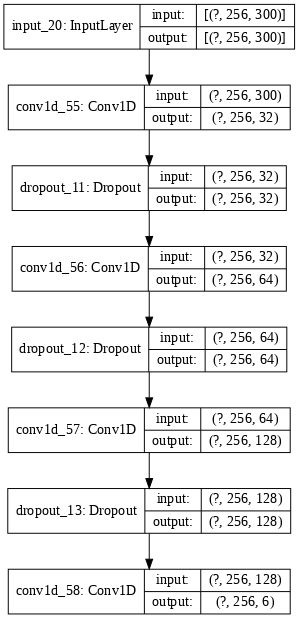

In [136]:
utils.plot_model(model_conv1d, dpi=70, show_shapes=True)

In [137]:
# Обучаю модель на conv1d сети
history = model_conv1d.fit(GENSIMtrainX, GENSIMtrainY, epochs=5, batch_size=200, validation_data=(GENSIMtestX, GENSIMtestY)) 

Epoch 1/5
67/67 [==============================] - 3s 51ms/step - loss: 1.2305 - dice_coef: 0.2396 - val_loss: 1.1087 - val_dice_coef: 0.2104
Epoch 2/5
67/67 [==============================] - 3s 47ms/step - loss: 1.2192 - dice_coef: 0.2429 - val_loss: 1.1011 - val_dice_coef: 0.2129
Epoch 3/5
67/67 [==============================] - 3s 47ms/step - loss: 1.2082 - dice_coef: 0.2461 - val_loss: 1.0936 - val_dice_coef: 0.2155
Epoch 4/5
67/67 [==============================] - 3s 46ms/step - loss: 1.1971 - dice_coef: 0.2495 - val_loss: 1.0861 - val_dice_coef: 0.2181
Epoch 5/5
67/67 [==============================] - 3s 47ms/step - loss: 1.1862 - dice_coef: 0.2529 - val_loss: 1.0787 - val_dice_coef: 0.2208


###Обучаю сеть conv1d_LSTM:

In [154]:
# Обучаю модель на conv1d_LSTM сети
model_conv1d_LSTM = create_conv1d_LSTM(xLen, embeddingSize)

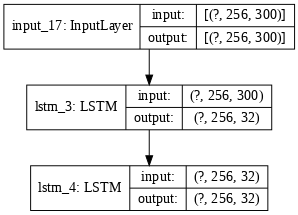

In [155]:
utils.plot_model(model_LSTM, dpi=70, show_shapes=True)

In [156]:
# обучаю модель conv1d_LSTM
history = model_conv1d_LSTM.fit(GENSIMtrainX, GENSIMtrainY, epochs=5, batch_size=200, validation_data=(GENSIMtestX, GENSIMtestY))

Epoch 1/5
67/67 [==============================] - 41s 612ms/step - loss: 1.2937 - dice_coef: 0.2292 - val_loss: 1.1562 - val_dice_coef: 0.2058
Epoch 2/5
67/67 [==============================] - 42s 624ms/step - loss: 1.2933 - dice_coef: 0.2294 - val_loss: 1.1603 - val_dice_coef: 0.2060
Epoch 3/5
67/67 [==============================] - 41s 617ms/step - loss: 1.2920 - dice_coef: 0.2297 - val_loss: 1.1580 - val_dice_coef: 0.2062
Epoch 4/5
67/67 [==============================] - 40s 601ms/step - loss: 1.2910 - dice_coef: 0.2300 - val_loss: 1.1565 - val_dice_coef: 0.2064
Epoch 5/5
67/67 [==============================] - 41s 619ms/step - loss: 1.2894 - dice_coef: 0.2302 - val_loss: 1.1564 - val_dice_coef: 0.2066


###Обучаю сеть UNET:

In [55]:
# обучаю модель UNET
model_b_UNET = create_unet(input_shape=(xLen, embeddingSize))
#model_b_UNET.summary()

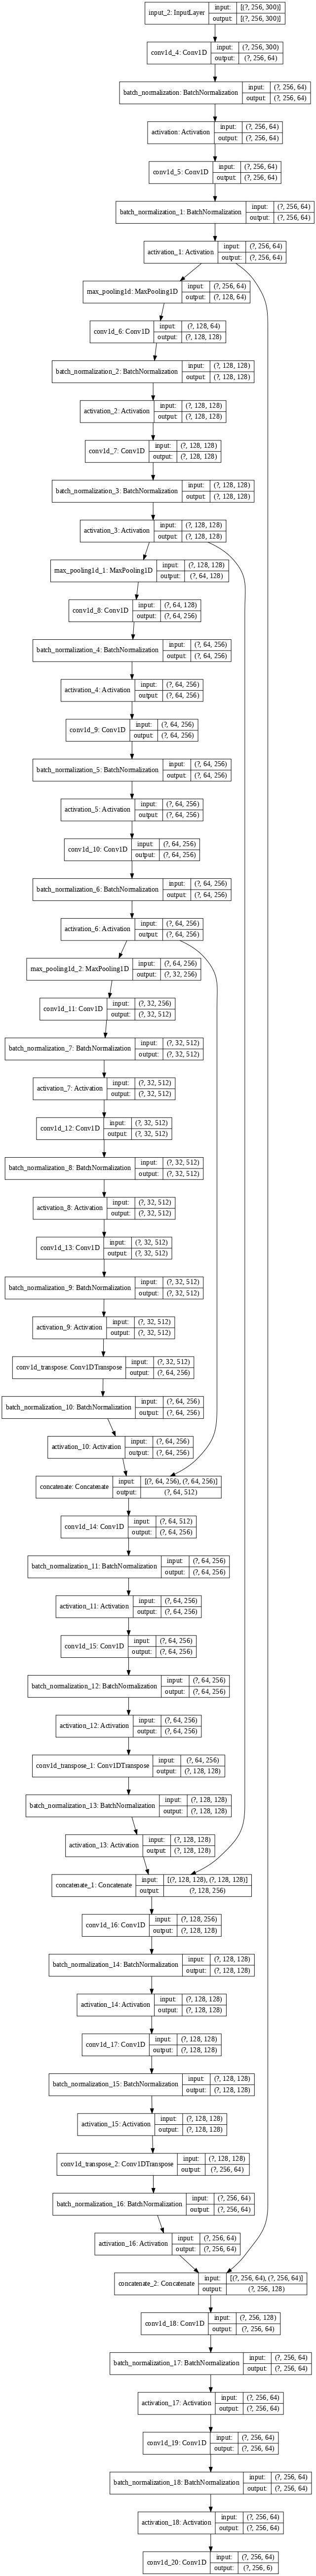

In [57]:
utils.plot_model(model_b_UNET, dpi=70, show_shapes=True)

In [58]:
history = model_b_UNET.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=64) # Feed the images divided among 2 classes to the model

Epoch 1/5
210/210 [==============================] - 18s 83ms/step - loss: 0.5313 - dice_coef: 0.5465 - val_loss: 1.9497 - val_dice_coef: 0.3486
Epoch 2/5
210/210 [==============================] - 17s 80ms/step - loss: 0.3411 - dice_coef: 0.6437 - val_loss: 1.1724 - val_dice_coef: 0.4355
Epoch 3/5
210/210 [==============================] - 17s 79ms/step - loss: 0.2917 - dice_coef: 0.6768 - val_loss: 0.9234 - val_dice_coef: 0.4504
Epoch 4/5
210/210 [==============================] - 17s 79ms/step - loss: 0.2640 - dice_coef: 0.6999 - val_loss: 1.1858 - val_dice_coef: 0.5077
Epoch 5/5
210/210 [==============================] - 17s 79ms/step - loss: 0.2479 - dice_coef: 0.7141 - val_loss: 1.1604 - val_dice_coef: 0.4681


###Обучаю сеть UNET_2:

In [164]:
# модель UNET_2
model_b_UNET_2 = create_unet_2(input_shape=(xLen, embeddingSize))

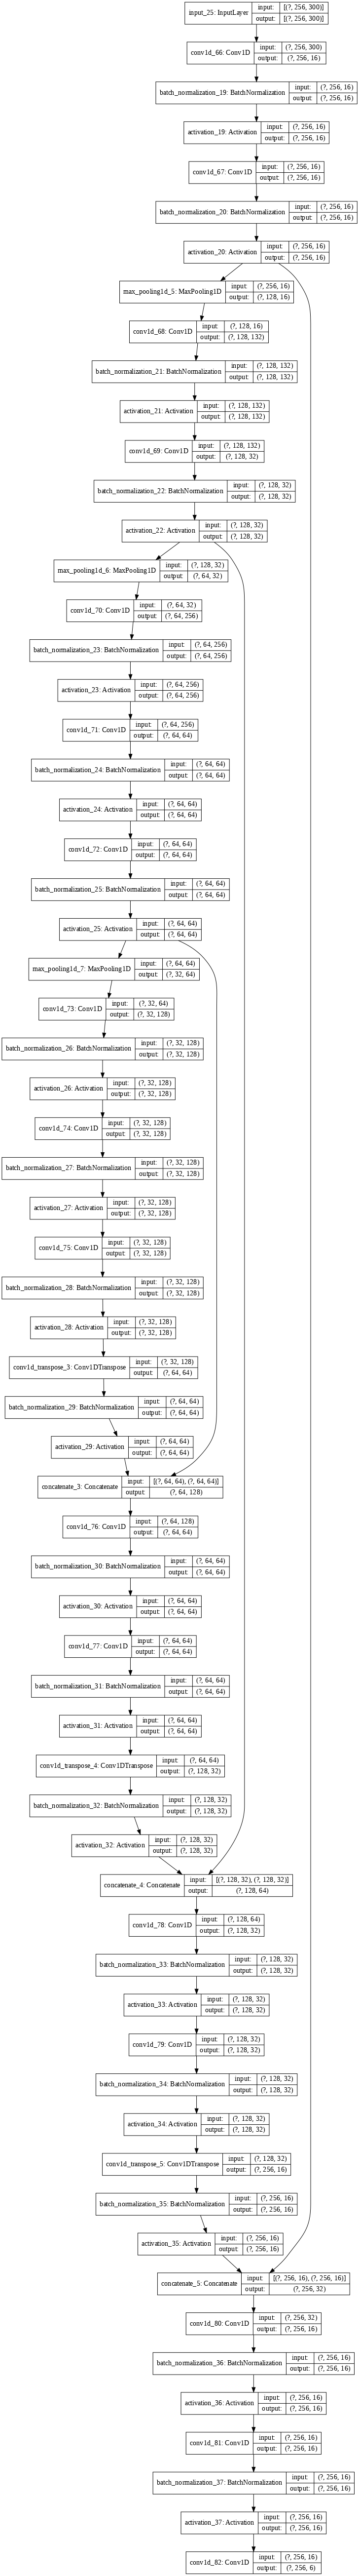

In [160]:
utils.plot_model(model_b_UNET_2, dpi=70, show_shapes=True)

In [161]:
# Обучаю сеть UNET_2
history = model_b_UNET_2.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=64)

Epoch 1/5
210/210 [==============================] - 9s 42ms/step - loss: 0.7018 - dice_coef: 0.4327 - val_loss: 0.6612 - val_dice_coef: 0.4510
Epoch 2/5
210/210 [==============================] - 7s 32ms/step - loss: 0.4640 - dice_coef: 0.5471 - val_loss: 0.6876 - val_dice_coef: 0.4835
Epoch 3/5
210/210 [==============================] - 7s 32ms/step - loss: 0.3860 - dice_coef: 0.5963 - val_loss: 0.8113 - val_dice_coef: 0.5002
Epoch 4/5
210/210 [==============================] - 7s 32ms/step - loss: 0.3403 - dice_coef: 0.6240 - val_loss: 0.7160 - val_dice_coef: 0.5092
Epoch 5/5
210/210 [==============================] - 7s 31ms/step - loss: 0.3142 - dice_coef: 0.6424 - val_loss: 0.8094 - val_dice_coef: 0.5313


###Обучаю сеть UNET_3:

In [165]:
# Сеть UNET_3
model_b_UNET_3 = create_unet_3(input_shape=(xLen, embeddingSize))

In [166]:
# Обучаю сеть UNET_3
history = model_b_UNET_3.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=64)

Epoch 1/5
210/210 [==============================] - 6s 30ms/step - loss: 0.7882 - dice_coef: 0.4180 - val_loss: 0.6471 - val_dice_coef: 0.4618
Epoch 2/5
210/210 [==============================] - 6s 27ms/step - loss: 0.5517 - dice_coef: 0.5305 - val_loss: 0.7481 - val_dice_coef: 0.4602
Epoch 3/5
210/210 [==============================] - 6s 27ms/step - loss: 0.4917 - dice_coef: 0.5514 - val_loss: 0.6730 - val_dice_coef: 0.4697
Epoch 4/5
210/210 [==============================] - 6s 28ms/step - loss: 0.4551 - dice_coef: 0.5655 - val_loss: 0.7073 - val_dice_coef: 0.4710
Epoch 5/5
210/210 [==============================] - 6s 27ms/step - loss: 0.4253 - dice_coef: 0.5779 - val_loss: 0.6890 - val_dice_coef: 0.4690


###Обучаю сеть UNET_4:

In [180]:
# модель UNET_4
model_b_UNET_4 = create_unet_4(input_shape=(xLen, embeddingSize))

In [181]:
# Обучаю сеть UNET_4
history = model_b_UNET_4.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=64)

Epoch 1/5
210/210 [==============================] - 9s 41ms/step - loss: 0.7085 - dice_coef: 0.4592 - val_loss: 0.8088 - val_dice_coef: 0.4726
Epoch 2/5
210/210 [==============================] - 8s 37ms/step - loss: 0.4738 - dice_coef: 0.5719 - val_loss: 0.8907 - val_dice_coef: 0.4630
Epoch 3/5
210/210 [==============================] - 8s 38ms/step - loss: 0.3966 - dice_coef: 0.6087 - val_loss: 0.7335 - val_dice_coef: 0.5216
Epoch 4/5
210/210 [==============================] - 8s 40ms/step - loss: 0.3635 - dice_coef: 0.6273 - val_loss: 0.6504 - val_dice_coef: 0.5315
Epoch 5/5
210/210 [==============================] - 8s 38ms/step - loss: 0.3317 - dice_coef: 0.6469 - val_loss: 0.8169 - val_dice_coef: 0.5047


###Обучаю сеть UNET_5:

In [184]:
# модель UNET_5
model_b_UNET_5 = create_unet_5(input_shape=(xLen, embeddingSize))

In [189]:
# Обучаю сеть UNET_5
history = model_b_UNET_5.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=128)

Epoch 1/5
105/105 [==============================] - 10s 97ms/step - loss: 0.2258 - dice_coef: 0.7325 - val_loss: 0.8585 - val_dice_coef: 0.5806
Epoch 2/5
105/105 [==============================] - 8s 78ms/step - loss: 0.2121 - dice_coef: 0.7479 - val_loss: 0.9046 - val_dice_coef: 0.5796
Epoch 3/5
105/105 [==============================] - 8s 77ms/step - loss: 0.2083 - dice_coef: 0.7542 - val_loss: 0.9909 - val_dice_coef: 0.5829
Epoch 4/5
105/105 [==============================] - 8s 77ms/step - loss: 0.2060 - dice_coef: 0.7590 - val_loss: 1.0293 - val_dice_coef: 0.5783
Epoch 5/5
105/105 [==============================] - 8s 76ms/step - loss: 0.2039 - dice_coef: 0.7627 - val_loss: 1.0622 - val_dice_coef: 0.5813


In [ ]:
###################################################################################################################

###Проверяю работу сети, опеделяю точность:

In [59]:
def recognizeSet(XX, YY, model, tags, length, value):
    correct_list = np.array([0] * 6)                  # массив правильных ответов в нули (сколько раз правильно определили класс)
    incorrect_list =  np.array([0] * 6)               # массив неправильных ответов в нули  (сколько раз неправильно определили класс)
    XX_array = XX
    YY_array = YY
    pred = model.predict(XX_array)
    pred[pred < value] = 0
    pred[pred > value] = 1

    for element in range(YY_array.shape[0]):          # по всем примерам в батче
      for word in range(YY_array.shape[1]):           # по каждому слову
        for category in range(YY_array.shape[2]):     # по каждой категории в слове
          if pred[element][word][category] == YY_array[element][word][category]:  # если предсказанное значение совпадает с истинным:
            correct_list[category] += 1               # отмечаем правильно предсказанный класс объекта
          else:                                       # если предсказанное значение НЕ совпадает с истенным:
            incorrect_list[category] += 1             # отмечаем, что не правильно предсказан класс объекта
        
    # Итоговая точность для каждого класса = кол. 100% * правильных/(кол. неправильных + кол. правильных)
    for i in range(6):
        print("Сеть распознала категорию  '{}' с точностью в {}%".format(tags[i], round(100*correct_list[i]/(correct_list[i] + incorrect_list[i]), 2)))
        total = round(100*np.mean(correct_list/(correct_list + incorrect_list)),2) 
    print("Средняя точность {}%".format(total))

In [60]:
print('Размер xTrain:', GENSIMtestX.shape)
print('Размер yTrain:', GENSIMtestY.shape)

Размер xTrain: (359, 256, 300)
Размер yTrain: (359, 256, 6)


In [61]:
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
# s1 Условия
# s2 Запреты
# s3 Стоимость (услуг и прочее)
# s4 Условия (относительно дат - дедлайны)
# s5 Штрафы
# s6 Адреса и местоположения

In [138]:
print("Проверка Conv1d сети:")
recognizeSet(GENSIMtestX, GENSIMtestY, model_conv1d, tags, xLen, 0.5)

Проверка Conv1d сети:
Сеть распознала категорию  'S1' с точностью в 31.43%
Сеть распознала категорию  'S2' с точностью в 97.89%
Сеть распознала категорию  'S3' с точностью в 40.12%
Сеть распознала категорию  'S4' с точностью в 45.15%
Сеть распознала категорию  'S5' с точностью в 57.55%
Сеть распознала категорию  'S6' с точностью в 9.9%
Средняя точность 47.01%


In [157]:
print("Проверка conv1d_LSTM сети:")
recognizeSet(GENSIMtestX, GENSIMtestY, model_conv1d_LSTM, tags, xLen, 0.5)

Проверка conv1d_LSTM сети:
Сеть распознала категорию  'S1' с точностью в 43.05%
Сеть распознала категорию  'S2' с точностью в 86.46%
Сеть распознала категорию  'S3' с точностью в 16.18%
Сеть распознала категорию  'S4' с точностью в 31.03%
Сеть распознала категорию  'S5' с точностью в 13.9%
Сеть распознала категорию  'S6' с точностью в 98.51%
Средняя точность 48.19%


In [63]:
print("Проверка UNET сети:")
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_UNET, tags, xLen, 0.1) 

Проверка UNET сети:
Сеть распознала категорию  'S1' с точностью в 80.29%
Сеть распознала категорию  'S2' с точностью в 96.47%
Сеть распознала категорию  'S3' с точностью в 46.03%
Сеть распознала категорию  'S4' с точностью в 70.73%
Сеть распознала категорию  'S5' с точностью в 72.94%
Сеть распознала категорию  'S6' с точностью в 98.66%
Средняя точность 77.52%


In [162]:
print("Проверка UNET_2 сети:")
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_UNET_2, tags, xLen, 0.1) 

Проверка UNET_2 сети:
Сеть распознала категорию  'S1' с точностью в 49.43%
Сеть распознала категорию  'S2' с точностью в 95.47%
Сеть распознала категорию  'S3' с точностью в 81.74%
Сеть распознала категорию  'S4' с точностью в 85.04%
Сеть распознала категорию  'S5' с точностью в 90.43%
Сеть распознала категорию  'S6' с точностью в 92.44%
Средняя точность 82.43%


In [167]:
print("Проверка UNET_3 сети:")
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_UNET_3, tags, xLen, 0.1)

Проверка UNET_3 сети:
Сеть распознала категорию  'S1' с точностью в 52.83%
Сеть распознала категорию  'S2' с точностью в 97.3%
Сеть распознала категорию  'S3' с точностью в 78.15%
Сеть распознала категорию  'S4' с точностью в 62.13%
Сеть распознала категорию  'S5' с точностью в 79.87%
Сеть распознала категорию  'S6' с точностью в 91.6%
Средняя точность 76.98%


In [182]:
print("Проверка UNET_4 сети:")
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_UNET_4, tags, xLen, 0.1)

Проверка UNET_4 сети:
Сеть распознала категорию  'S1' с точностью в 63.84%
Сеть распознала категорию  'S2' с точностью в 93.37%
Сеть распознала категорию  'S3' с точностью в 67.28%
Сеть распознала категорию  'S4' с точностью в 76.07%
Сеть распознала категорию  'S5' с точностью в 89.66%
Сеть распознала категорию  'S6' с точностью в 89.69%
Средняя точность 79.98%


In [190]:
print("Проверка UNET_5 сети:")
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_UNET_5, tags, xLen, 0.1)

Проверка UNET_5 сети:
Сеть распознала категорию  'S1' с точностью в 71.13%
Сеть распознала категорию  'S2' с точностью в 97.58%
Сеть распознала категорию  'S3' с точностью в 79.55%
Сеть распознала категорию  'S4' с точностью в 84.96%
Сеть распознала категорию  'S5' с точностью в 92.58%
Сеть распознала категорию  'S6' с точностью в 96.58%
Средняя точность 87.06%


In [208]:
df = pd.DataFrame({"Conv1d":[47.01], "Conv1d_LSTM":[48.19], "UNET":[77.52], "UNET_2":[82.43], "UNET_3":[76.98], "UNET_4":[79.98],
           "UNET_5":[87.06]})
df.index = ["Средняя точность распознавания в %:"] 
df

,Conv1d,Conv1d_LSTM,UNET,UNET_2,UNET_3,UNET_4,UNET_5
Средняя точность распознавания в %:,47.01,48.19,77.52,82.43,76.98,79.98,87.06
